## Setting up InfluxDB connection

### Making sure to use singleton principle

In [71]:
# --- InfluxDB Singleton Client Setup ---
import os
from influxdb_client.client.influxdb_client import InfluxDBClient
import pandas as pd

class InfluxSingleton:
    _client = None
    _query_api = None
    _params = {}

    @classmethod
    def init(cls, url, token, org, bucket):
        if cls._client is None:
            cls._client = InfluxDBClient(url=url, token=token, org=org)
            cls._query_api = cls._client.query_api()
            cls._params = {'org': org, 'bucket': bucket}

    @classmethod
    def get_query_api(cls):
        if cls._query_api is None:
            raise Exception("InfluxSingleton not initialized. Call InfluxSingleton.init(url, token, org, bucket) first.")
        return cls._query_api

    @classmethod
    def get_params(cls):
        if not cls._params:
            raise Exception("InfluxSingleton not initialized. Call InfluxSingleton.init(url, token, org, bucket) first.")
        return cls._params

In [72]:
# Load environment variables from .env
from dotenv import load_dotenv
load_dotenv()

import os
INFLUX_URL = os.getenv('INFLUXDB_URL')
INFLUX_TOKEN = os.getenv('INFLUXDB_TOKEN')
INFLUX_ORG = os.getenv('INFLUXDB_ORG')
INFLUX_BUCKET = os.getenv('INFLUXDB_BUCKET')

### Getting data

In [73]:
# --- Robust Stock Data Fetch Function ---
def get_stock_data(ticker, start="2021-01-03", stop="2025-06-20"):
    params = InfluxSingleton.get_params()
    bucket = params['bucket']
    org = params['org']
    query = f'''
    from(bucket: "{bucket}")
      |> range(start: {start}T00:00:00Z, stop: {stop}T00:00:00Z)
      |> filter(fn: (r) => r["_measurement"] == "stock_data")
      |> filter(fn: (r) => r["symbol"] == "{ticker}")
      |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
      |> keep(columns: ["_time", "open", "high", "low", "close", "volume", "turnover"])
      |> sort(columns: ["_time"])
    '''
    try:
        query_api = InfluxSingleton.get_query_api()
        result = query_api.query_data_frame(org=org, query=query)
        if isinstance(result, list):
            df = pd.concat(result)
        else:
            df = result.copy()
        if df.empty:
            print(f"No data found for {ticker} in range {start} to {stop}.")
            return df
        df.rename(columns={"_time": "time"}, inplace=True)
        df["time"] = pd.to_datetime(df["time"])
        df.set_index("time", inplace=True)
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()


In [74]:
# --- Example Usage: Initialize Client (edit with your credentials) ---
InfluxSingleton.init(INFLUX_URL, INFLUX_TOKEN, INFLUX_ORG, INFLUX_BUCKET)

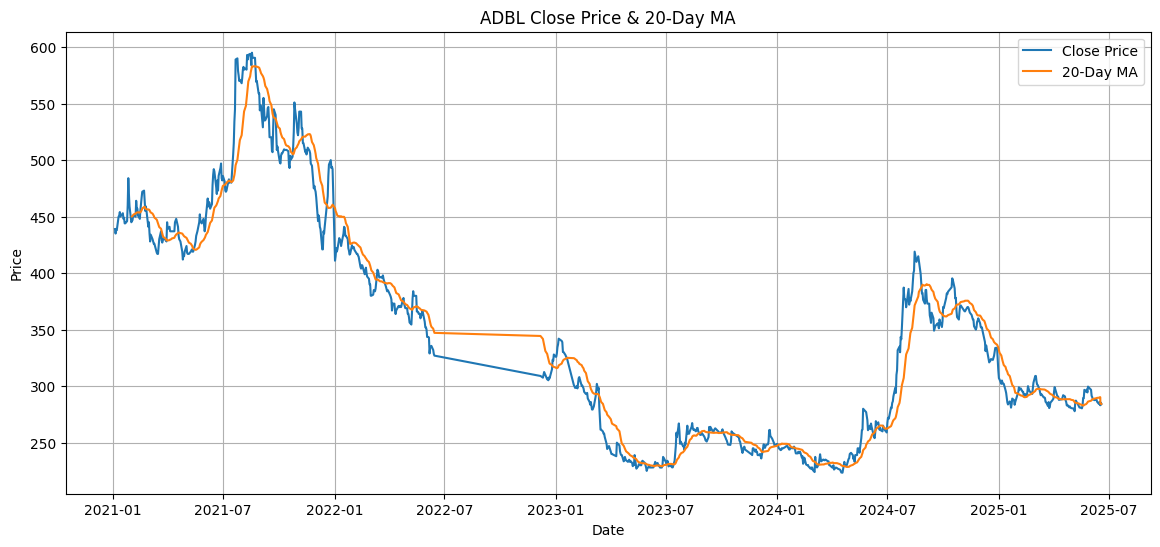

In [75]:
# --- Example Analysis: Fetch, Plot, Moving Average, Correlation ---
import matplotlib.pyplot as plt

ticker = 'ADBL'
df = get_stock_data(ticker, start='2021-01-03', stop='2025-06-20')

if not df.empty:
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['close'], label='Close Price')
    # Moving Average
    window = 20
    df['ma'] = df['close'].rolling(window=window).mean()
    plt.plot(df.index, df['ma'], label=f'{window}-Day MA')
    plt.title(f'{ticker} Close Price & {window}-Day MA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()
    # Correlation Example (if you fetch more than one ticker)
    # df2 = get_stock_data('NABIL', start='2023-01-01', stop='2024-12-31')
    # if not df2.empty:
    #     corr = df['close'].corr(df2['close'])
    #     print(f'Correlation between {ticker} and NABIL: {corr:.3f}')
else:
    print('No data to plot.')

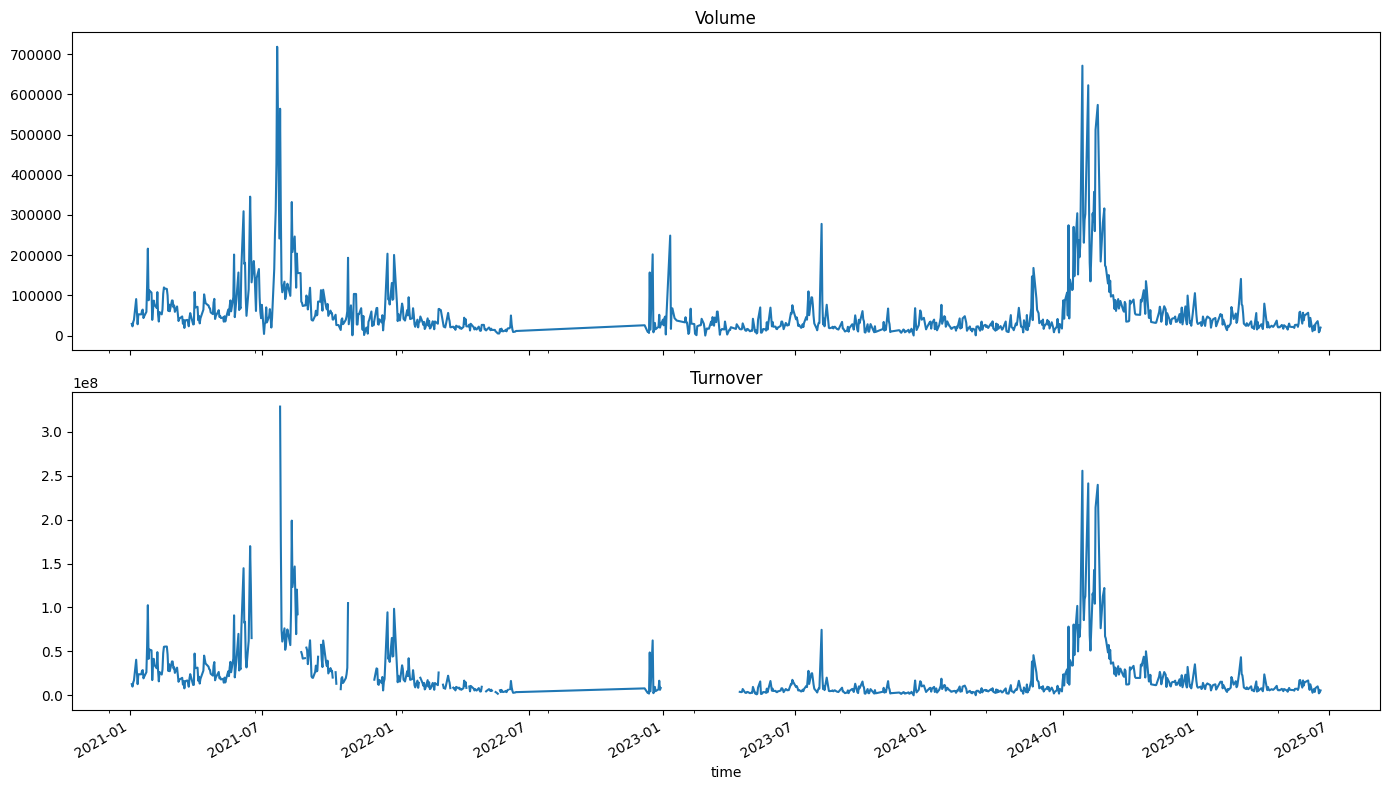

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

df["volume"].plot(ax=ax[0], title="Volume")
df["turnover"].plot(ax=ax[1], title="Turnover")

plt.tight_layout()
plt.show()


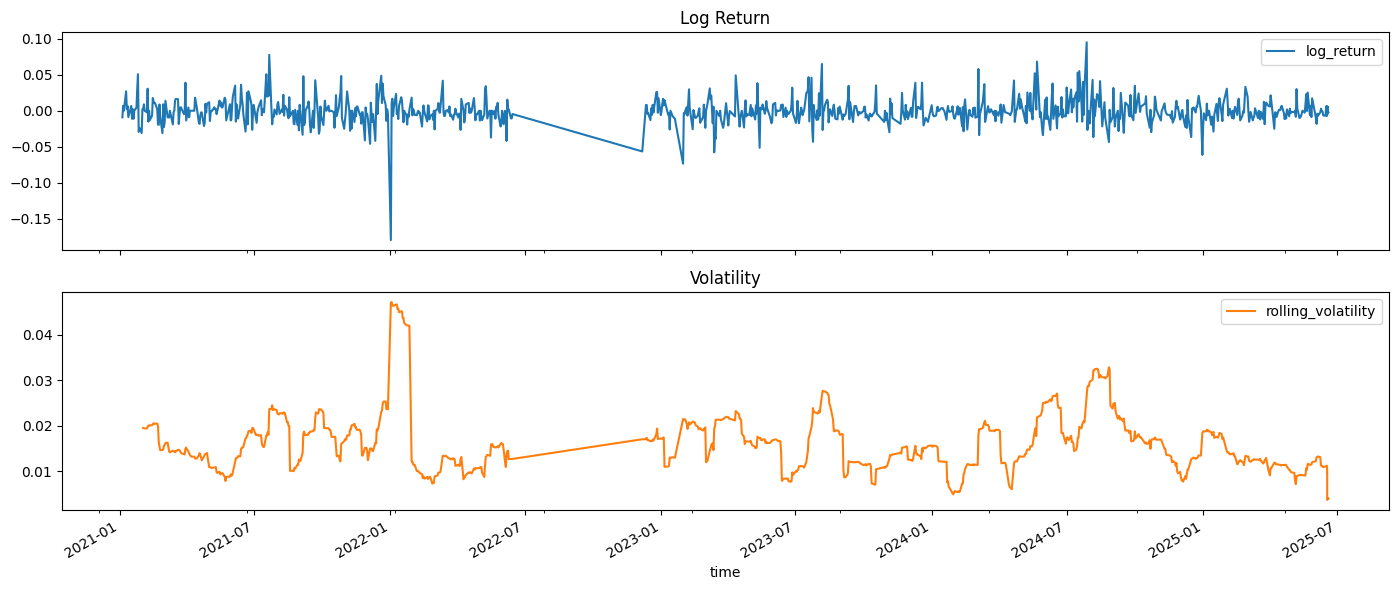

In [77]:
import numpy as np

df["log_return"] = (df["close"] / df["close"].shift(1)).apply(lambda x: np.log(x))
df["rolling_volatility"] = df["log_return"].rolling(20).std()

df[["log_return", "rolling_volatility"]].plot(subplots=True, figsize=(14, 6), title=["Log Return", "Volatility"])
plt.tight_layout()
plt.show()


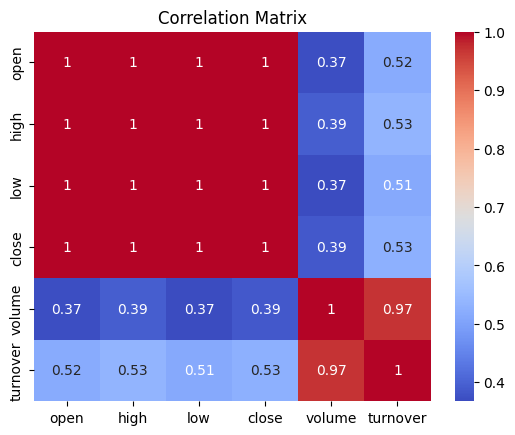

In [78]:
corr = df[["open", "high", "low", "close", "volume", "turnover"]].corr()
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()



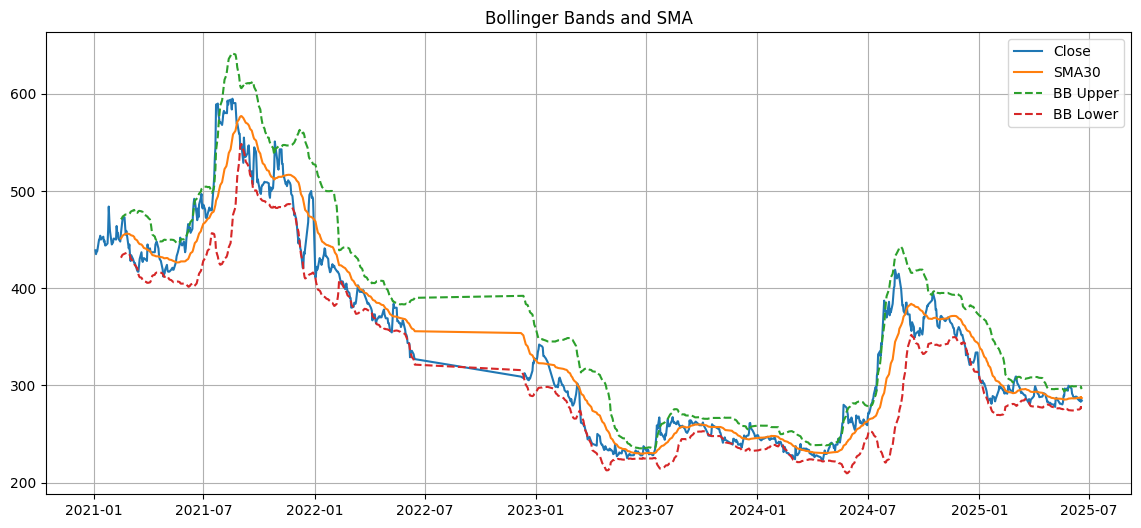

In [79]:
df["SMA30"] = df["close"].rolling(window=30).mean()
df["SMA100"] = df["close"].rolling(window=100).mean()

# Bollinger Bands
df["BB_upper"] = df["SMA30"] + 2 * df["close"].rolling(window=30).std()
df["BB_lower"] = df["SMA30"] - 2 * df["close"].rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(df["close"], label="Close")
plt.plot(df["SMA30"], label="SMA30")
plt.plot(df["BB_upper"], label="BB Upper", linestyle='--')
plt.plot(df["BB_lower"], label="BB Lower", linestyle='--')
plt.legend()
plt.title("Bollinger Bands and SMA")
plt.grid()
plt.show()


In [81]:
df = get_stock_data("ADBL", start="2021-01-01")
df = df[["close"]].copy()
df.dropna(inplace=True)


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load data
df = get_stock_data("ADBL", start="2021-01-01")
df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df.dropna(inplace=True)

# Tune p and q (d=0 since using log returns)
best_aic = float("inf")
best_order = None
best_model = None

for p in range(4):   # Try p = 0 to 3
    for q in range(4):   # Try q = 0 to 3
        try:
            model = ARIMA(df["log_return"], order=(p, 0, q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, 0, q)
                best_model = result
            print(f"Tested ARIMA({p},0,{q}) AIC: {result.aic:.2f}")
        except:
            print(f"ARIMA({p},0,{q}) failed.")
            continue

print(f"\n✅ Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

Tested ARIMA(0,0,0) AIC: -4388.73
Tested ARIMA(0,0,1) AIC: -4388.06


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Tested ARIMA(0,0,2) AIC: -4386.07
Tested ARIMA(0,0,3) AIC: -4384.81
Tested ARIMA(1,0,0) AIC: -4388.05


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

Tested ARIMA(1,0,1) AIC: -4386.11
Tested ARIMA(1,0,2) AIC: -4384.55


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Tested ARIMA(1,0,3) AIC: -4384.17
Tested ARIMA(2,0,0) AIC: -4386.06


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

Tested ARIMA(2,0,1) AIC: -4384.06


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Tested ARIMA(2,0,2) AIC: -4383.80


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

Tested ARIMA(2,0,3) AIC: -4383.21
Tested ARIMA(3,0,0) AIC: -4384.51
Tested ARIMA(3,0,1) AIC: -4382.57


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

Tested ARIMA(3,0,2) AIC: -4381.90


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Tested ARIMA(3,0,3) AIC: -4380.13

✅ Best ARIMA order: (0, 0, 0) with AIC: -4388.73


In [90]:
model = ARIMA(df["log_return"], order=(p, 0, q))  # ARIMA(1,0,1) on log returns
fitted_model = model.fit()
print(fitted_model.summary())

n_days = 30
forecasted_returns = fitted_model.forecast(steps=n_days)

C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                  830
Model:                 ARIMA(3, 0, 3)   Log Likelihood                2198.066
Date:                Tue, 24 Jun 2025   AIC                          -4380.133
Time:                        13:54:39   BIC                          -4342.361
Sample:                             0   HQIC                         -4365.648
                                - 830                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.356      0.722      -0.002       0.001
ar.L1         -0.1847      3.398     -0.054      0.957      -6.845       6.476
ar.L2          0.1727      1.656      0.104      0.9

C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [91]:
last_price = df["close"].iloc[-1]
predicted_prices = [last_price]

for r in forecasted_returns:
    predicted_prices.append(predicted_prices[-1] * np.exp(r))

# Remove first known price
predicted_prices = predicted_prices[1:]

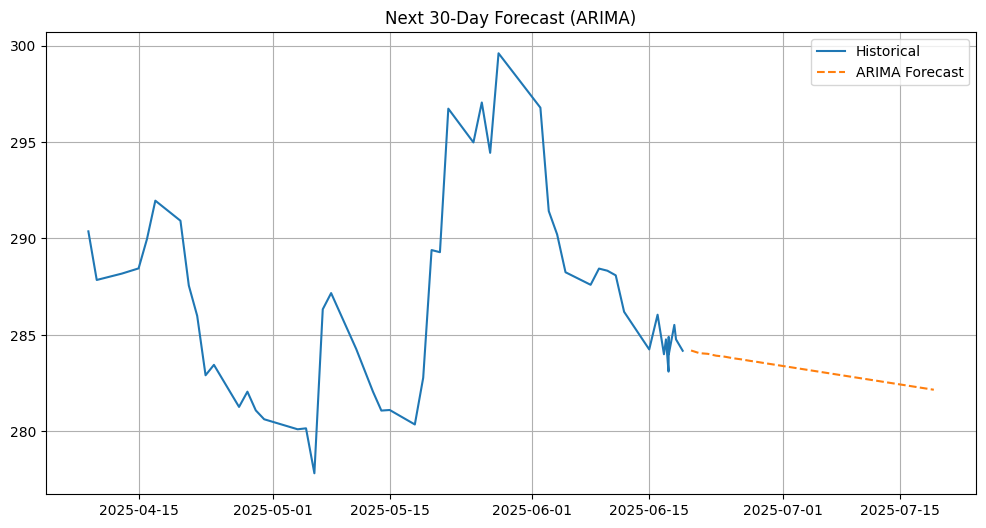

In [92]:
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_days, freq="D")

plt.figure(figsize=(12, 6))
plt.plot(df.index[-60:], df["close"].tail(60), label="Historical")
plt.plot(future_dates, predicted_prices, label="ARIMA Forecast", linestyle='--')
plt.title("Next 30-Day Forecast (ARIMA)")
plt.legend()
plt.grid()
plt.show()

In [101]:
from arch import arch_model
import pandas as pd
import numpy as np

# Prepare returns (in percentage scale)
df = get_stock_data("ADBL", start="2021-01-01")
df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df.dropna(inplace=True)
returns = df["log_return"] * 100

# Grid search over (p, q)
best_aic = float("inf")
best_order = None
best_model = None

for p in range(1, 4):    # Try p = 1 to 3
    for q in range(1, 4):  # Try q = 1 to 3
        try:
            model = arch_model(returns, vol="GARCH", p=p, q=q)
            result = model.fit(disp="off")
            print(f"GARCH({p},{q}) AIC: {result.aic:.2f}")
            
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, q)
                best_model = result
        except Exception as e:
            print(f"GARCH({p},{q}) failed: {e}")

print(f"\n✅ Best GARCH Order: {best_order} with AIC: {best_aic:.2f}")

GARCH(1,1) AIC: 3174.50
GARCH(1,2) AIC: 3176.50
GARCH(1,3) AIC: 3178.50
GARCH(2,1) AIC: 3176.47
GARCH(2,2) AIC: 3177.75
GARCH(2,3) AIC: 3178.81
GARCH(3,1) AIC: 3178.32
GARCH(3,2) AIC: 3180.21
GARCH(3,3) AIC: 3178.59

✅ Best GARCH Order: (1, 1) with AIC: 3174.50


In [102]:
forecast_horizon = 30
forecast = result.forecast(horizon=forecast_horizon)

# Get forecasted conditional variance (1-step ahead, 2-step ahead, ...)
predicted_variance = forecast.variance.values[-1, :]  # Most recent forecast
predicted_volatility = np.sqrt(predicted_variance)    # Std deviation (volatility)


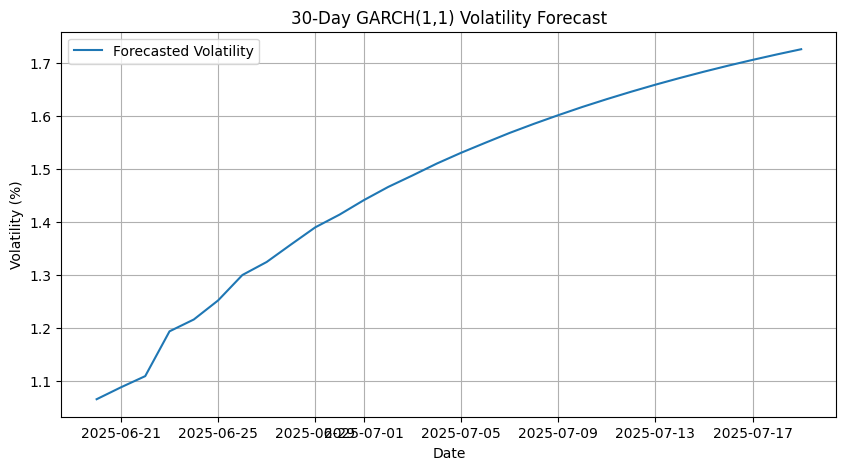

In [103]:
import matplotlib.pyplot as plt

future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq="D")

plt.figure(figsize=(10, 5))
plt.plot(future_dates, predicted_volatility, label="Forecasted Volatility")
plt.title("30-Day GARCH(1,1) Volatility Forecast")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid()
plt.legend()
plt.show()


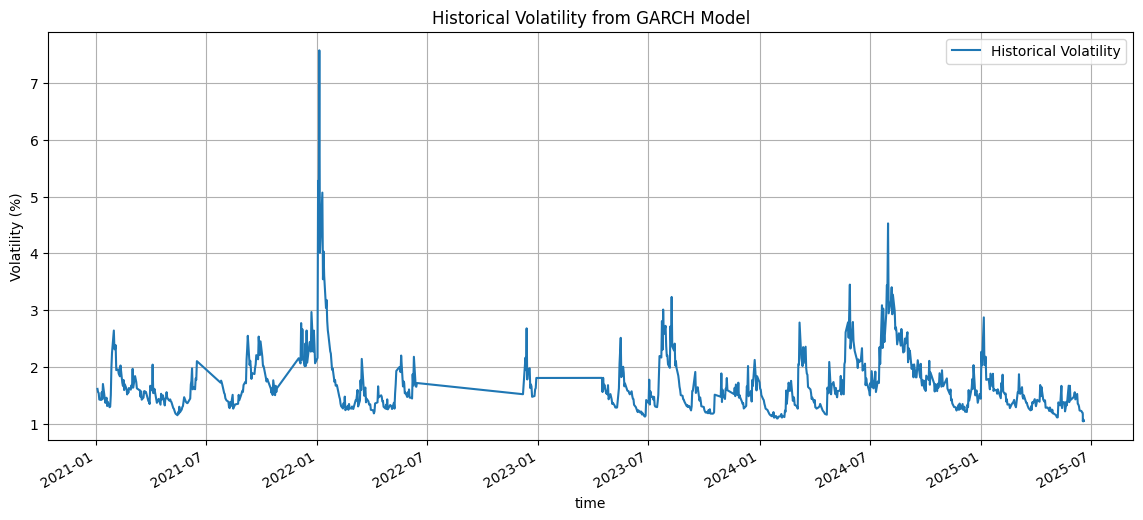

In [104]:
df["volatility"] = result.conditional_volatility

plt.figure(figsize=(14, 6))
df["volatility"].plot(label="Historical Volatility")
plt.title("Historical Volatility from GARCH Model")
plt.ylabel("Volatility (%)")
plt.grid()
plt.legend()
plt.show()


In [105]:
import numpy as np
import pandas as pd

df = get_stock_data("ADBL", start="2021-01-01")
df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df.dropna(inplace=True)

returns = df["log_return"] * 100  # Scale to percentage


In [106]:
from statsmodels.tsa.arima.model import ARIMA

# Choose (p,d,q); here (1,0,1) as example
arima_model = ARIMA(returns, order=(1, 0, 1))
arima_result = arima_model.fit()

# Get residuals (what ARIMA couldn’t explain)
residuals = arima_result.resid


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [107]:
from arch import arch_model

garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')

print(garch_result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1581.35
Distribution:                  Normal   AIC:                           3170.71
Method:            Maximum Likelihood   BIC:                           3189.59
                                        No. Observations:                  830
Date:                Tue, Jun 24 2025   Df Residuals:                      829
Time:                        14:03:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0309  5.148e-02     -0.601      0.548 [ -0.132,

In [108]:
# Forecast next 30 days mean return using ARIMA
n_days = 30
arima_forecast = arima_result.get_forecast(steps=n_days)
predicted_returns = arima_forecast.predicted_mean.values

# Forecast volatility from GARCH
garch_forecast = garch_result.forecast(horizon=n_days)
predicted_variance = garch_forecast.variance.values[-1, :]
predicted_volatility = np.sqrt(predicted_variance)


C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Daniel\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [109]:
last_price = df["close"].iloc[-1]
predicted_prices = [last_price]

for r in predicted_returns:
    predicted_prices.append(predicted_prices[-1] * np.exp(r / 100))

predicted_prices = predicted_prices[1:]


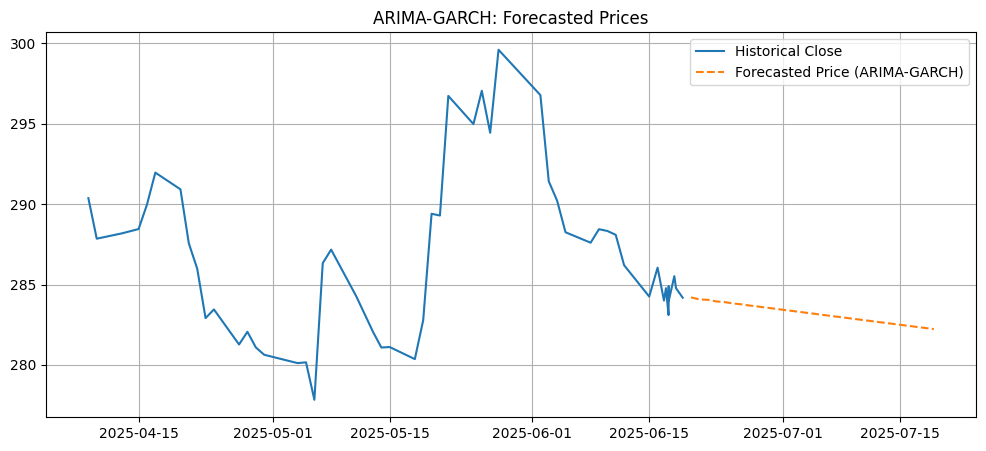

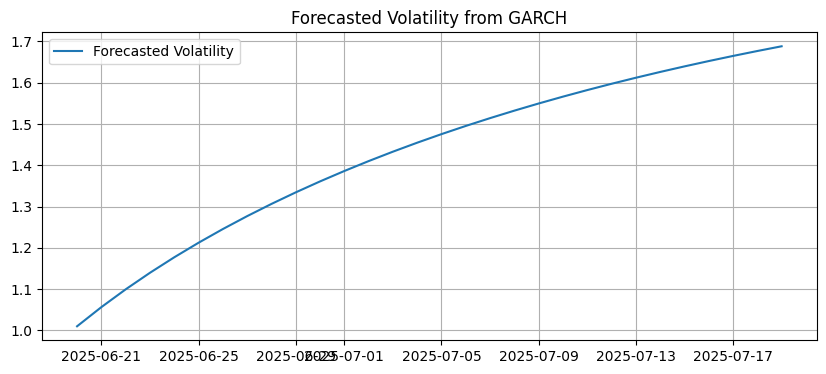

In [110]:
import matplotlib.pyplot as plt

future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_days, freq="D")

plt.figure(figsize=(12, 5))
plt.plot(df.index[-60:], df["close"].tail(60), label="Historical Close")
plt.plot(future_dates, predicted_prices, label="Forecasted Price (ARIMA-GARCH)", linestyle='--')
plt.title("ARIMA-GARCH: Forecasted Prices")
plt.grid()
plt.legend()
plt.show()

# Plot volatility
plt.figure(figsize=(10, 4))
plt.plot(future_dates, predicted_volatility, label="Forecasted Volatility")
plt.title("Forecasted Volatility from GARCH")
plt.grid()
plt.legend()
plt.show()
